# Experiments with Measured Data - CDF Results

This notebooks reproduces the CDFs of Section IV-C of the paper ["Learning Radio Environments by
Differentiable Ray Tracing"](https://arxiv.org/abs/2311.18558) by J. Hoydis, F. Ait Aoudia, S. Cammerer, F. Euchner, M. Nimier-David, S. ten Brink, and A. Keller, Dec. 2023.

The code is made available under the [NVIDIA License](https://github.com/NVlabs/diff-rt-calibration/blob/main/LICENSE.txt).

To generate the CDFs, you need first to:

- Download the "dichasus-dc01.tfrecords" file from the [DICHASUS website](https://dichasus.inue.uni-stuttgart.de/datasets/data/dichasus-dcxx/) to the folder `data/tfrecords` within the cloned repository. More information about the DICHASUS channel sounder can be found [here](https://arxiv.org/abs/2206.15302).

- Create a dataset of traced paths using the script [gen_dataset.py](../code/gen_dataset.py). For this purpose, ensure that you are in the `code/` folder, and run:
```bash
python gen_dataset.py -traced_paths_dataset dichasus-dc01 -traced_paths_dataset_size 10000
```
This script stores the generated dataset in the `data/traced_paths/` folder.
Generating the dataset of traced paths can take a while.

- Train the models by running the corresponding notebooks ([ITU Materials](ITU_Materials.ipynb), [Learned Materials](Learned_Materials.ipynb) and [Neural Materials](Neural_Materials.ipynb)). The weights of the trained models are saved in the `checkpoints/` folder.

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

%matplotlib widget
import matplotlib.pyplot as plt
import sys
import json
from matplotlib.lines import Line2D

sys.path.append('../code')

import sionna
from sionna.utils import log10
from utils import *
from trainable_materials import  TrainableMaterials
from neural_materials import  NeuralMaterials
import pickle


In [2]:
# Size of validation set size
validation_set_size = 100
test_set_size = 4900
batch_size = 16

num_subcarriers = 1024
bandwidth = 50e6

# Sizes of the training set to evaluate
training_set_size = 5000

# Folder where to save the results
res_folder = "../results/measurements/"
# Pickle file storing the results
result_filename = res_folder + 'CDF_results.pkl'


You can load pre-existing results (next cell) and directly jump to the end of this notebook to plot them, or run the entire notebook starting from the cell after the next to compute the results.

In [3]:
with open(result_filename, 'rb') as f:
    RT_CDFs, MS_CDFs, Err_CDFs = pickle.load(f)


In [ ]:
# Dict storing the results
RT_CDFs = {'Power' : {},
           'Delay spread' : {}}

MS_CDFs = {'Power' : None,
           'Delay spread' : None}

Err_CDFs = {'Power' : {},
            'Delay spread' : {}}


In [ ]:
# Simple scene dataset
# Dataset
dataset_name = '../data/traced_paths/dichasus-dc01'
dataset_filename = os.path.join(dataset_name + '.tfrecords')
params_filename = os.path.join(dataset_name + '.json')
dataset = tf.data.TFRecordDataset([dataset_filename]).map(deserialize_paths_as_tensor_dicts)

with open(params_filename, 'r') as openfile:
    params_simple = json.load(openfile)

# Validation set is independant on the size of the training set
_, _, test_set_simple = split_dataset(dataset, params_simple['traced_paths_dataset_size'], training_set_size, validation_set_size, test_set_size)


In [ ]:
def evaluate_errors(scene, scaling_factor, params, test_set, scattering):

    ##########################################
    # Compute the powers and RMS delay spread
    # over the test set
    ##########################################

    _, h_rt, h_meas = ds_ray_trace(scene, scaling_factor, params, test_set, batch_size, test_set_size, num_subcarriers, bandwidth, scattering)

    ###########################################
    # Compute the errors
    ###########################################

    meas_powers = []
    rt_powers = []

    meas_delay_spreads = []
    rt_delay_spreads = []

    powers_errors = []
    delay_spread_errors = []

    for tx in (0,1):
        h_rt_ = h_rt[:,tx]
        h_meas_ = h_meas[:,tx]

        # Compute the total power (sum over subcarriers)
        pow_rt = tf.reduce_sum(tf.square(tf.abs(h_rt_)), axis=-1)
        pow_meas = tf.reduce_sum(tf.square(tf.abs(h_meas_)), axis=-1)
        rt_powers.append(tf.reshape(10.0*log10(pow_rt), [-1]))
        meas_powers.append(tf.reshape(10.0*log10(pow_meas), [-1]))

        # RMS delay spread
        # RT CIR
        h_rt_, t_rt = freq2time(h_rt_)
        ds_rt = rms_delay_spread(h_rt_, t_rt*1e9)
        rt_delay_spreads.append(tf.reshape(ds_rt, [-1]))
        # Measured CIR
        h_meas_, t_meas = freq2time(h_meas_)
        ds_meas = rms_delay_spread(h_meas_, t_meas*1e9)
        meas_delay_spreads.append(tf.reshape(ds_meas, [-1]))

        # Error on powers
        pow_errors_ = ale(pow_rt, pow_meas)
        powers_errors.append(pow_errors_)

        # Error on RMS delay spreads
        ds_errors_ = relative_abs_error(ds_rt, ds_meas)
        delay_spread_errors.append(ds_errors_)
    powers_errors = tf.concat(powers_errors, axis=0)
    delay_spread_errors = tf.concat(delay_spread_errors, axis=0)
    meas_powers = tf.concat(meas_powers, axis=0)
    rt_powers = tf.concat(rt_powers, axis=0)
    meas_delay_spreads = tf.concat(meas_delay_spreads, axis=0)
    rt_delay_spreads = tf.concat(rt_delay_spreads, axis=0)

    return meas_powers, rt_powers, meas_delay_spreads, rt_delay_spreads, powers_errors, delay_spread_errors


# ITU Materials

In [ ]:
# Load the scene
scene = init_scene(params_simple['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", 'itu_materials')
with open(mat_filename, 'rb') as f:
    scaling_factor = pickle.load(f)

outputs = evaluate_errors(scene, scaling_factor, params_simple, test_set_simple, scattering=False)

RT_CDFs['Power']['ITU Materials'] = outputs[1].numpy()
RT_CDFs['Delay spread']['ITU Materials'] = outputs[3].numpy()

MS_CDFs['Power'] = outputs[0].numpy()
MS_CDFs['Delay spread'] = outputs[2].numpy()

Err_CDFs['Power']['ITU Materials'] = outputs[4].numpy()
Err_CDFs['Delay spread']['ITU Materials'] = outputs[5].numpy()


# Learned Materials

In [ ]:
# Load the scene
scene = init_scene(params_simple['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", "learned_materials")
num_objects = len(scene.objects)
learned_mat = TrainableMaterials(scene, num_objects, embedding_size=30, learn_scattering=False)
learned_mat(tf.zeros([1], tf.int32), tf.zeros([1,3], tf.float32)) # Dummy run to build the model
scaling_factor = load_model(learned_mat, mat_filename)
scene.radio_material_callable = learned_mat

outputs = evaluate_errors(scene, scaling_factor, params_simple, test_set_simple, scattering=False)

RT_CDFs['Power']['Learned Materials'] = outputs[1].numpy()
RT_CDFs['Delay spread']['Learned Materials'] = outputs[3].numpy()

Err_CDFs['Power']['Learned Materials'] = outputs[4].numpy()
Err_CDFs['Delay spread']['Learned Materials'] = outputs[5].numpy()


# Neural Materials

In [ ]:
# Load the scene
scene = init_scene(params_simple['scene_name'], use_tx_array=True)

# Place the transmitters
place_transmitter_arrays(scene, [1,2])

# Instantitate receivers
instantiate_receivers(scene, batch_size)

mat_filename = os.path.join("../checkpoints", "neural_materials")
neural_mat = NeuralMaterials(scene, learn_scattering=False)
neural_mat(tf.zeros([1], tf.int32), tf.zeros([1,3])) # Dummy run to build the model
scaling_factor = load_model(neural_mat, mat_filename)
scene.radio_material_callable = neural_mat

outputs = evaluate_errors(scene, scaling_factor, params_simple, test_set_simple, scattering=False)

RT_CDFs['Power']['Neural Materials'] = outputs[1].numpy()
RT_CDFs['Delay spread']['Neural Materials'] = outputs[3].numpy()

Err_CDFs['Power']['Neural Materials'] = outputs[4].numpy()
Err_CDFs['Delay spread']['Neural Materials'] = outputs[5].numpy()


# Save results

In [ ]:
with open(result_filename, 'wb') as f:
    pickle.dump((RT_CDFs, MS_CDFs, Err_CDFs), f)


# Plot

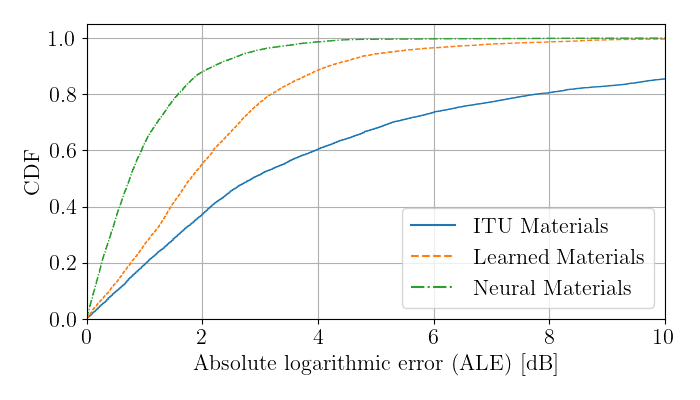

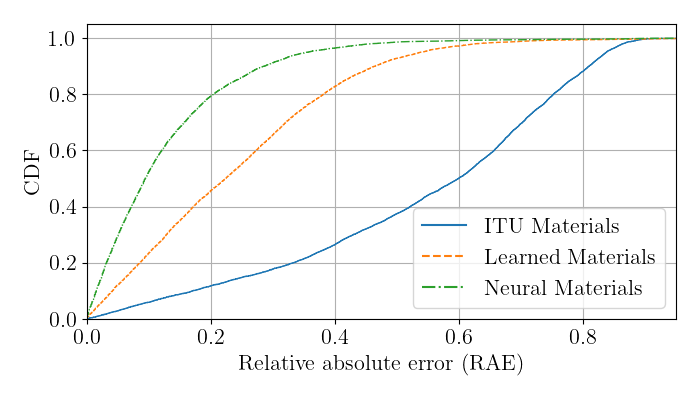

In [4]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'figure.autolayout': True})

handles = []
labels = []
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
#
ax.hist(Err_CDFs['Power']['ITU Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-', color='C0')
handles.append(Line2D([], [], c='C0', linestyle='-'))
labels.append('ITU Materials')
#
ax.hist(Err_CDFs['Power']['Learned Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='--', color='C1')
handles.append(Line2D([], [], c='C1', linestyle='--'))
labels.append('Learned Materials')
#
ax.hist(Err_CDFs['Power']['Neural Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-.', color='C2')
handles.append(Line2D([], [], c='C2', linestyle='-.'))
labels.append('Neural Materials')
#
plt.grid(True)
plt.legend(handles=handles, labels=labels)
plt.xlim((0, 10))
plt.xlabel(r'Absolute logarithmic error (ALE) [dB]')
plt.ylabel('CDF')
plt.tight_layout()
plt.savefig(res_folder + 'power_ale.pdf')

handles = []
lables = []
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
#
ax.hist(Err_CDFs["Delay spread"]["ITU Materials"], 1000, cumulative=True, density=True, histtype='step', linestyle='-', color='C0')
handles.append(Line2D([], [], c='C0', linestyle='-'))
labels.append(r'ITU Materials')
#
ax.hist(Err_CDFs["Delay spread"]["Learned Materials"], 1000, cumulative=True, density=True, histtype='step', linestyle='--', color='C1')
handles.append(Line2D([], [], c='C1', linestyle='--'))
labels.append(r'Learned Materials')
#
ax.hist(Err_CDFs["Delay spread"]["Neural Materials"], 1000, cumulative=True, density=True, histtype='step', linestyle='-.', color='C2')
handles.append(Line2D([], [], c='C2', linestyle='-.'))
labels.append(r'Neural Materials')
#
plt.grid(True)
plt.legend(handles=handles, labels=labels)
plt.xlim((0, 0.95))
plt.xlabel(r'Relative absolute error (RAE)')
plt.ylabel(r'CDF')
plt.savefig(res_folder + 'ds_rae.pdf')


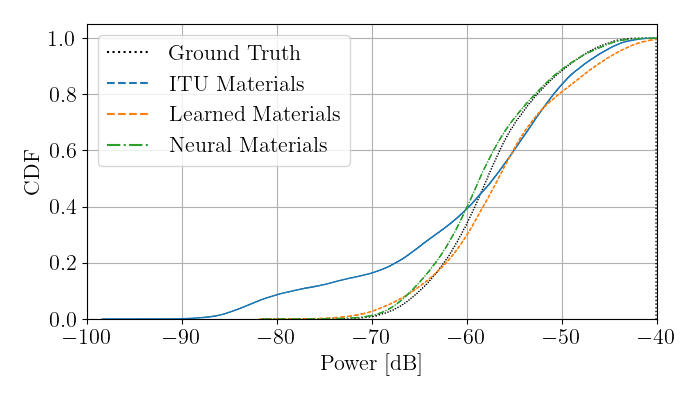

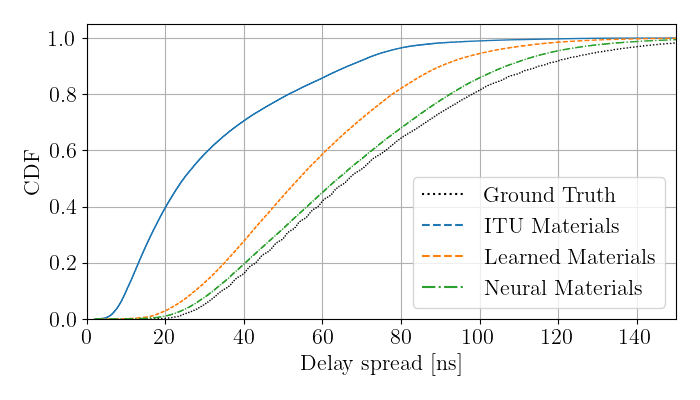

In [5]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'figure.autolayout': True})

handles = []
labels = []
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
#
ax.hist(MS_CDFs['Power'], 1000, cumulative=True, density=True, histtype='step', linestyle=':', color='k')
handles.append(Line2D([], [], c='k', linestyle=':'))
labels.append('Ground Truth')
#
ax.hist(RT_CDFs['Power']['ITU Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-', color='C0')
handles.append(Line2D([], [], c='C0', linestyle='--'))
labels.append('ITU Materials')
#
ax.hist(RT_CDFs['Power']['Learned Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='--', color='C1')
handles.append(Line2D([], [], c='C1', linestyle='--'))
labels.append('Learned Materials')
#
ax.hist(RT_CDFs['Power']['Neural Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-.', color='C2')
handles.append(Line2D([], [], c='C2', linestyle='-.'))
labels.append('Neural Materials')
#
plt.grid(True)
plt.legend(handles=handles, labels=labels)
plt.xlim((-100, -40))
plt.xlabel(r'Power [dB]')
plt.ylabel('CDF')
plt.tight_layout()
plt.savefig(res_folder + 'power.pdf')

handles = []
lables = []
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
#
ax.hist(MS_CDFs['Delay spread'], 1000, cumulative=True, density=True, histtype='step', linestyle=':', color='k')
handles.append(Line2D([], [], c='k', linestyle=':'))
labels.append('Ground Truth')
#
ax.hist(RT_CDFs['Delay spread']['ITU Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-', color='C0')
handles.append(Line2D([], [], c='C0', linestyle='--'))
labels.append('ITU Materials')
#
ax.hist(RT_CDFs['Delay spread']['Learned Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='--', color='C1')
handles.append(Line2D([], [], c='C1', linestyle='--'))
labels.append('Learned Materials')
#
ax.hist(RT_CDFs['Delay spread']['Neural Materials'], 1000, cumulative=True, density=True, histtype='step', linestyle='-.', color='C2')
handles.append(Line2D([], [], c='C2', linestyle='-.'))
labels.append('Neural Materials')
#
plt.grid(True)
plt.legend(handles=handles, labels=labels)
plt.xlim((0, 150))
plt.xlabel(r'Delay spread [ns]')
plt.ylabel(r'CDF')
plt.savefig(res_folder + 'ds.pdf')
